# Simulating flow

With `bluebonnet.flow`, you can solve pseudopressure over time and calculate how production declines and recovery factor increases. First, a few imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    FlowPropertiesTwoPhase,
    SinglePhaseReservoir,
    RelPermParams,
    relative_permeabilities,
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

plt.style.use("ggplot")

In [2]:
def plot_pseudopressure(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(0, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x, p, color="steelblue")
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, 1), ylim=(0, 1.05))
    return fig, ax


def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale="squareroot", ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0, 1, 7) * np.sqrt(max(time))) ** 2, 1)
        ax.set_xticks(tick_locs)
    return ax

## Ideal gas simulation

In [3]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

CPU times: user 5.56 s, sys: 3.02 ms, total: 5.56 s
Wall time: 5.57 s


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

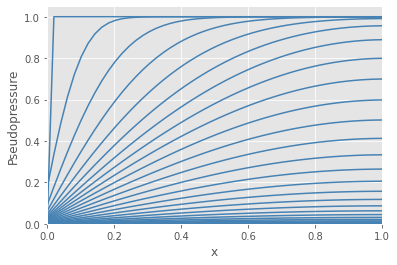

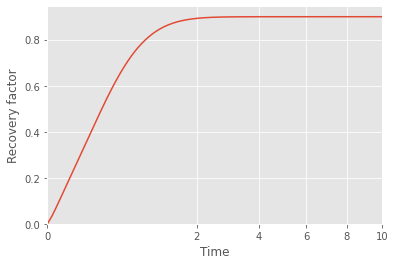

In [4]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

## Real gas simulation

<AxesSubplot:xlabel='pseudopressure', ylabel='diffusivity'>

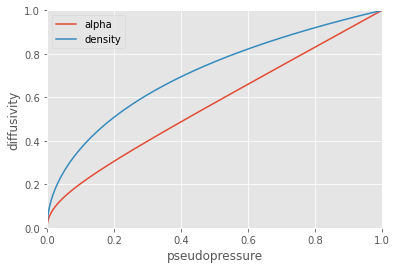

In [5]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)


def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1 / (x.compressibility * x.viscosity),
        density=lambda x: x.Density / max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min())
        / (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(alpha=lambda x: x.alpha / x.alpha.iloc[-1])[
        [
            "pressure",
            "pseudopressure",
            "alpha",
            "density",
            "z-factor",
            "compressibility",
            "viscosity",
        ]
    ]
    return out


fluid_properties = pvt_gas.pipe(scale_pressure_diffusivity)
ax = fluid_properties.plot(x="pseudopressure", y="alpha")
ax.set(ylim=(0, 1), xlim=(0, 1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax)

In [6]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

flow_properties = FlowProperties(fluid_properties, p_i=12_000)

res_realgas = SinglePhaseReservoir(50, 2000, 12000, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

CPU times: user 9.44 s, sys: 27.1 ms, total: 9.47 s
Wall time: 9.49 s


[(0.0, 0.1)]

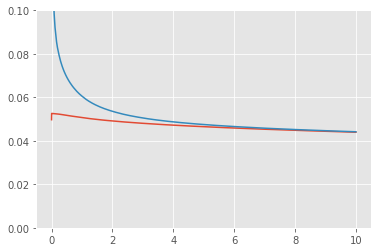

In [7]:
fig, ax = plt.subplots()
ax.plot(time, res_realgas.pseudopressure[:, :2])
ax.set(ylim=(0, 1e-1))

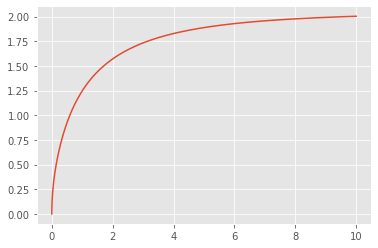

In [8]:
plt.plot(time, rf2)

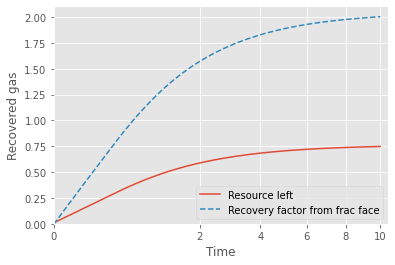

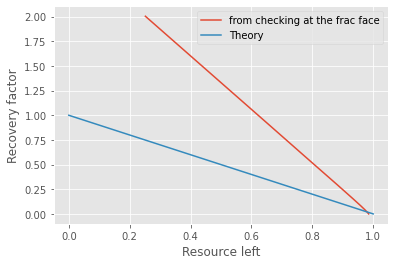

In [9]:
from scipy import interpolate

density_interp = interpolate.interp1d(
    flow_properties.pvt_props["m-scaled"], flow_properties.pvt_props["density"]
)


def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt["pseudopressure"], pvt["density"])
    return (density(pseudopressure)).sum(axis=1)


remaining_gas = (
    resource_left(res_realgas.pseudopressure, flow_properties.pvt_props)
    / res_realgas.nx
)
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gas, label="Resource left")
ax.plot(time, rf2, "--", label="Recovery factor from frac face")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovered gas",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

fig, ax = plt.subplots()
ax.plot(remaining_gas, rf2, label="from checking at the frac face")
ax.plot([1, 0], [0, 1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

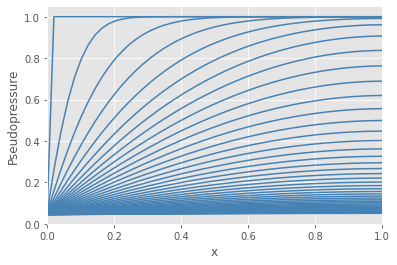

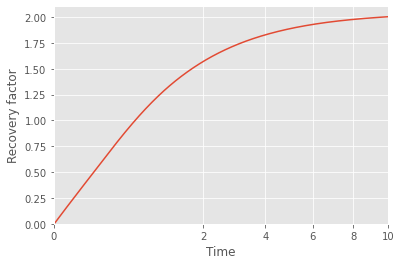

In [10]:
ax = plot_pseudopressure(res_realgas)

ax = plot_recovery_factor(res_realgas)
ax.set(xlabel="Time", ylabel="Recovery factor")

# Flow Curves

In [12]:
p_i = 12000
rf = {}
for p_f in np.linspace(500, 2000, 7):
    print("Starting", p_f)
    fluid_properties = pvt_gas[pvt_gas.pressure >= p_f].pipe(scale_pressure_diffusivity)
    flow_properties = FlowProperties(fluid_properties, p_i=p_i)
    res_realgas = SinglePhaseReservoir(50, p_f, p_i, flow_properties)

    %time res_realgas.simulate(time)
    rf[f"{p_f:.0f}"] = res_realgas.recovery_factor()

Starting 500.0
CPU times: user 7.68 s, sys: 16 ms, total: 7.7 s
Wall time: 7.73 s
Starting 750.0
CPU times: user 4.8 s, sys: 11 ms, total: 4.81 s
Wall time: 4.82 s
Starting 1000.0
CPU times: user 5.25 s, sys: 4.3 ms, total: 5.25 s
Wall time: 5.27 s
Starting 1250.0
CPU times: user 5.23 s, sys: 8.22 ms, total: 5.24 s
Wall time: 5.25 s
Starting 1500.0
CPU times: user 5.06 s, sys: 11.6 ms, total: 5.07 s
Wall time: 5.08 s
Starting 1750.0
CPU times: user 5.17 s, sys: 4.31 ms, total: 5.18 s
Wall time: 5.18 s
Starting 2000.0
CPU times: user 5.07 s, sys: 0 ns, total: 5.07 s
Wall time: 5.07 s


[None]

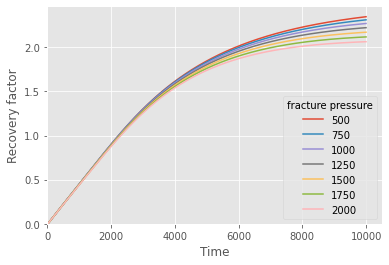

In [13]:
ax = pd.DataFrame(rf).plot()
ax.set(xlim=(0, None), ylim=(0, None), xlabel="Time", ylabel="Recovery factor")
ax.legend().set(title="fracture pressure")

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 2.103882773066951),
 None,
 (0.0, 10.500000000000002)]

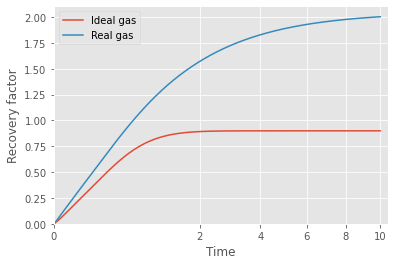

In [14]:
# ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovery factor",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

## Multiphase flow

### Set up PVT

[(1000.0, 6000.0), (0.0, 1.0), Text(0, 0.5, 'Value')]

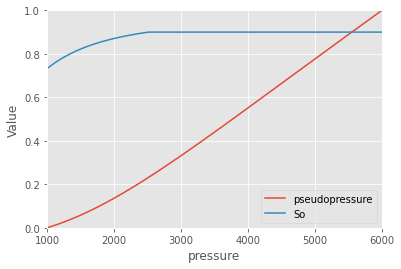

In [15]:
# set conditions
Sw = 0.1
p_frac = 1000
p_res = 6_000
phi = 0.1
fvf_scale = 1

# get pvt tables
pvt_oil = pd.read_csv("../tests/data/pvt_oil.csv")
pvt_water = pd.read_csv("../tests/data/pvt_water.csv").rename(
    columns={"T": "temperature", "P": "pressure", "Viscosity": "mu_w"}
)
df_pvt = (
    pvt_water.drop(columns=["temperature"])
    .merge(
        pvt_oil.rename(
            columns={
                "T": "temperature",
                "P": "pressure",
                "Oil_Viscosity": "mu_o",
                "Gas_Viscosity": "mu_g",
                "Rso": "Rs",
            }
        ),
        on="pressure",
    )
    .assign(Rv=0)
)

# calculate So, Sg assuming no mobile water
df_pvt_mp = df_pvt.copy()
df_pvt_mp["So"] = (1 - Sw) / (
    (df_pvt["Rs"].max() - df_pvt["Rs"]) * df_pvt["Bg"] / df_pvt["Bo"] / 5.61458 + 1
)

# scale pseudopressure
pseudopressure = interp1d(df_pvt.pressure, df_pvt.pseudopressure)
df_pvt_mp["pseudopressure"] = (
    pseudopressure(df_pvt_mp["pressure"]) - pseudopressure(p_frac)
) / (pseudopressure(p_res) - pseudopressure(p_frac))

fig, ax = plt.subplots()
df_pvt_mp.plot(x="pressure", y="pseudopressure", ax=ax)
df_pvt_mp.plot(x="pressure", y="So", ax=ax)
ax.set(xlim=(p_frac, p_res), ylim=(0, 1.0), ylabel="Value")

### Set up relative permeabilities

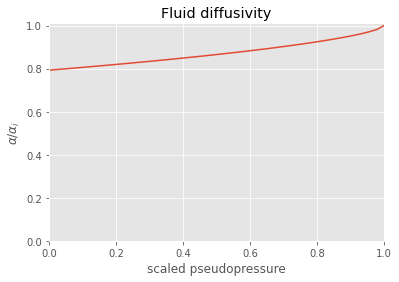

In [16]:
relperm_params = RelPermParams(
    n_o=1, n_g=1, n_w=1, S_or=0, S_gc=0, S_wc=0.1, k_ro_max=1, k_rw_max=1, k_rg_max=1
)
saturations_test = pd.DataFrame(
    {"So": np.linspace(0, 0.9), "Sw": np.full(50, 0.1), "Sg": np.linspace(0.9, 0)}
)
kr_matrix = pd.DataFrame(
    relative_permeabilities(saturations_test.to_records(index=False), relperm_params)
)
df_kr = pd.concat([saturations_test, kr_matrix], axis=1)
reference_densities = {"rho_o0": 141.5 / (45 + 131.5), "rho_g0": 1.03e-3, "rho_w0": 1}
flow_props = FlowPropertiesTwoPhase.from_table(
    df_pvt_mp, df_kr, reference_densities, phi, Sw, fvf_scale
)
m_scaled = np.linspace(0, 1)
fig, ax = plt.subplots()
ax.plot(m_scaled, flow_props.alpha(m_scaled) / flow_props.alpha(1))
ax.set(
    xlim=(0, 1),
    ylim=(0, None),
    xlabel="scaled pseudopressure",
    ylabel=r"$\alpha/\alpha_i$",
    title="Fluid diffusivity",
);

### Simulate

In [17]:
res = SinglePhaseReservoir(50, p_frac, p_res, flow_props)
t_end = 3
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res.simulate(time)
rf = res.recovery_factor()

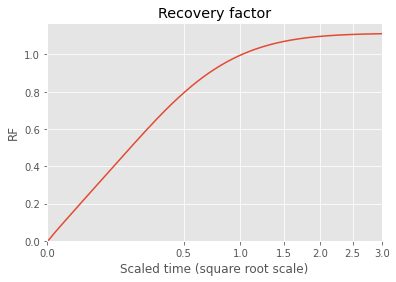

In [18]:
fig, ax = plt.subplots()
ax.plot(time, rf)
ax.set(
    xscale="squareroot",
    xlim=(0, t_end),
    ylim=(0, None),
    ylabel="RF",
    title="Recovery factor",
    xlabel="Scaled time (square root scale)",
);